In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Country-Konfiguration laden (mit verbesserter Länderauswahl)
import sys
sys.path.append('./utils')
from country_config import country_colors, g7, eu_core, extra_countries, all_selected_countries, get_selected_countries

# Plot-Konfiguration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# Datensets laden
df_co2 = pd.read_csv('../data/processed/co2_energy_data.csv')
df_econ = pd.read_csv('../data/processed/economic_indicators.csv')

CO2 Analyse - Letztes Jahr: 2023
Ausgewählte Länder: 21
CO2 Plot: 20 Länder geplottet


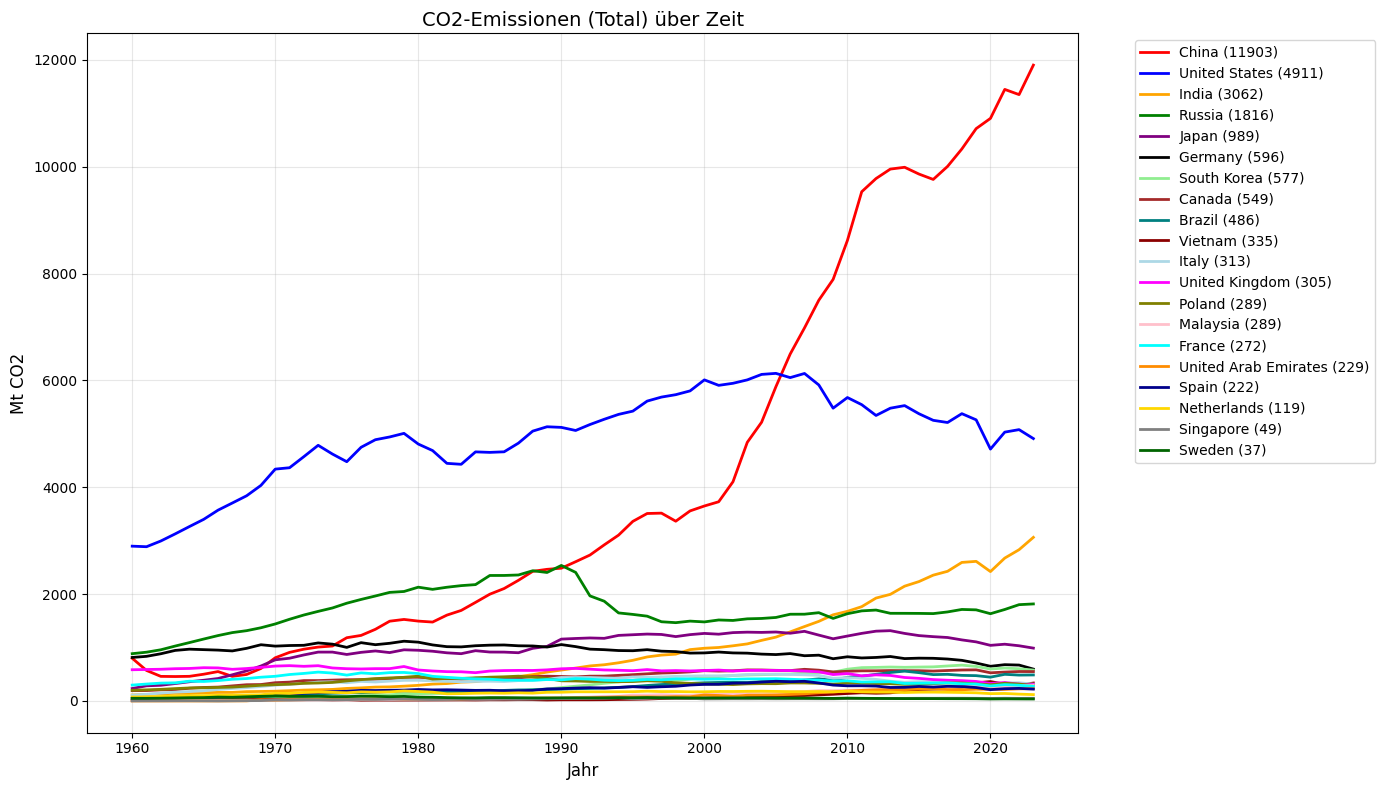

Verfügbare CO2-Quellen: ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement', 'CO2_flaring', 'CO2_other']


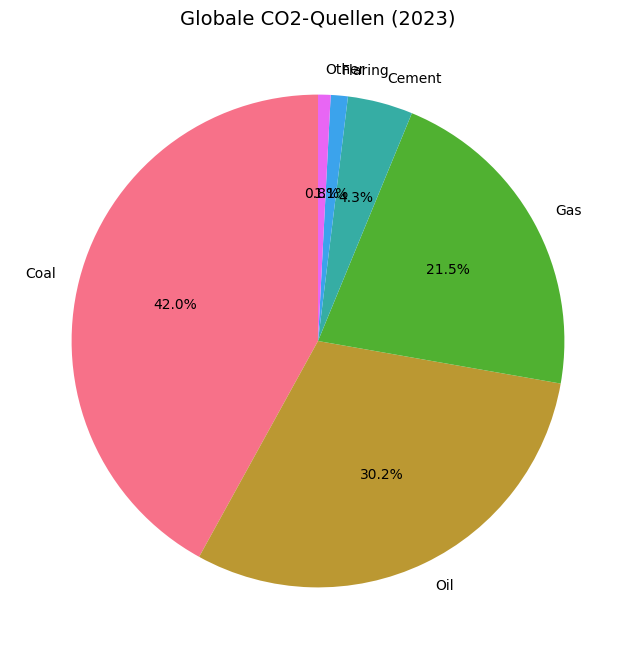

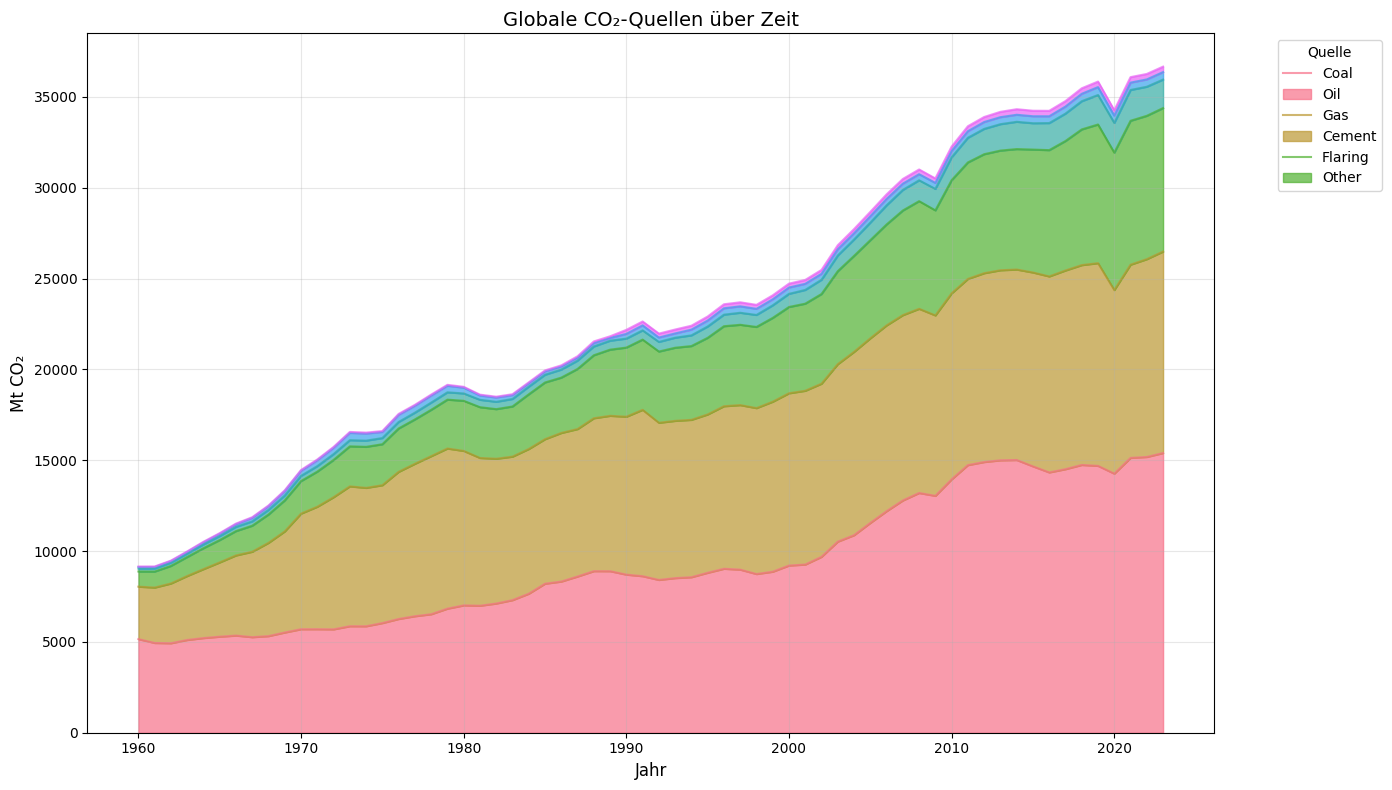


 CO2-VERGLEICH FÜR BESONDERE JAHRE 
Vergleich basierend auf: Gesamt-CO2-Emissionen (alle Quellen)
1989: 21 Länder verglichen
2008: 21 Länder verglichen
2015: 21 Länder verglichen


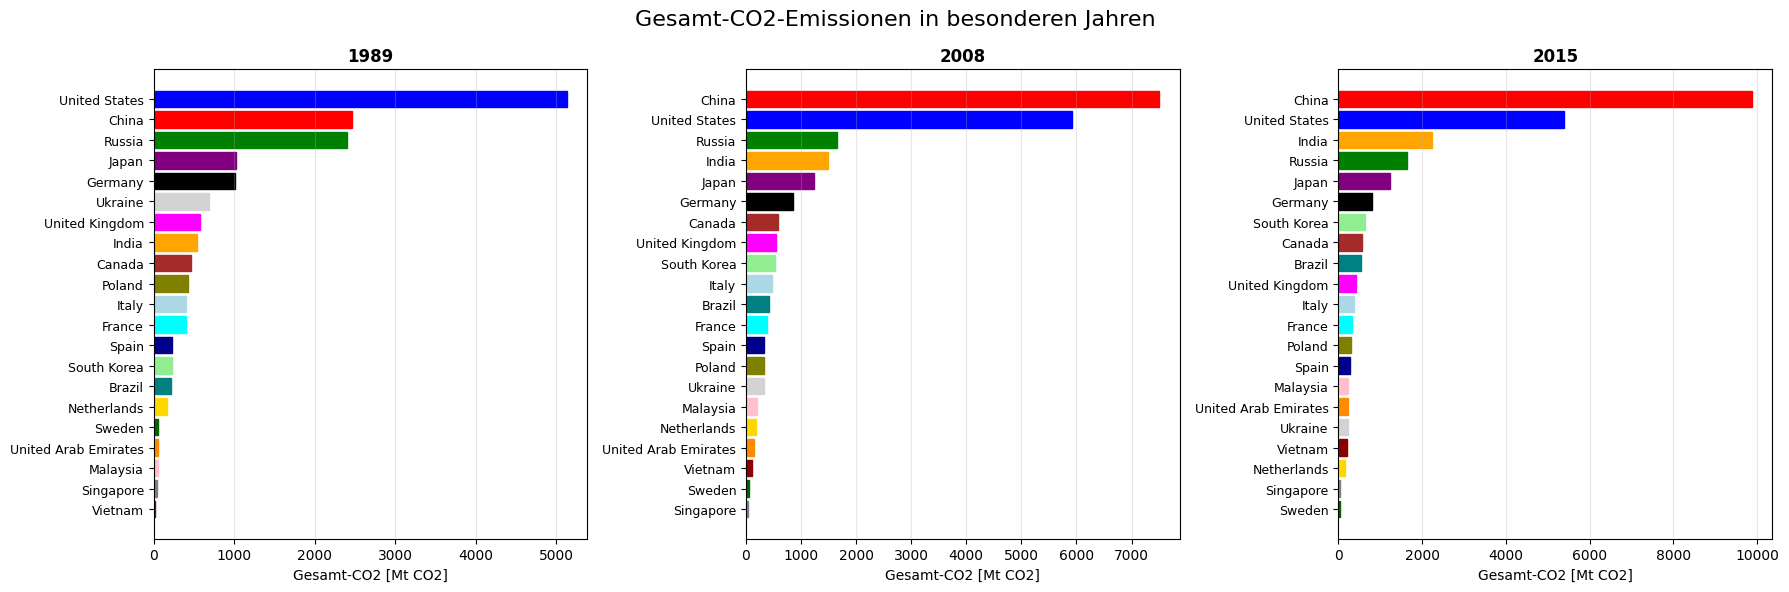

In [10]:
# CO2 & Energie Visualisierung
selected_countries = get_selected_countries(df_co2, 'CO2_total')
df_co2_selected = df_co2[df_co2['Country'].isin(selected_countries)]
latest_year_co2 = df_co2['Year'].max()
print(f"CO2 Analyse - Letztes Jahr: {latest_year_co2}")
print(f"Ausgewählte Länder: {len(selected_countries)}")

# CO2 Zeitreihe sortiert nach Emissionen im letzten Jahr
country_order = df_co2[df_co2['Year'] == latest_year_co2].set_index('Country')['CO2_total'].sort_values(ascending=False)
ordered_countries = [c for c in country_order.index if c in selected_countries]

plt.figure(figsize=(14, 8))
plotted_countries_co2 = 0

for country in ordered_countries:
    sub = df_co2_selected[df_co2_selected['Country'] == country]
    if country in country_colors and not sub.empty:
        latest_co2_data = sub[sub['Year'] == latest_year_co2]['CO2_total']
        if not latest_co2_data.empty:
            latest_value = latest_co2_data.values[0]
            valid_data = sub[sub['CO2_total'].notna()]
            if len(valid_data) > 1:
                plt.plot(valid_data['Year'], valid_data['CO2_total'], 
                        label=f"{country} ({latest_value:.0f})", 
                        color=country_colors[country], linewidth=2)
                plotted_countries_co2 += 1

print(f"CO2 Plot: {plotted_countries_co2} Länder geplottet")

if plotted_countries_co2 > 0:
    plt.title('CO2-Emissionen (Total) über Zeit', fontsize=14)
    plt.xlabel('Jahr', fontsize=12)
    plt.ylabel('Mt CO2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
plt.show()

# CO2-Quellen global (Pie Chart)
co2_sources = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement', 'CO2_flaring', 'CO2_other']
available_sources = [col for col in co2_sources if col in df_co2.columns]
print(f"Verfügbare CO2-Quellen: {available_sources}")

if available_sources:
    global_sources = df_co2.groupby('Year')[available_sources].sum().loc[latest_year_co2]
    # Entferne Quellen mit 0 oder NaN Werten
    global_sources = global_sources[global_sources > 0]
    
    if not global_sources.empty:
        plt.figure(figsize=(10, 8))
        plt.pie(global_sources, labels=[s.replace('CO2_', '').title() for s in global_sources.index],
                autopct='%1.1f%%', startangle=90)
        plt.title(f'Globale CO2-Quellen ({latest_year_co2})', fontsize=14)
        plt.show()

# CO2-Quellen im Zeitverlauf (Stacked Area Plot)
if available_sources:
    df_sources = df_co2.groupby('Year')[available_sources].sum().dropna()
    if not df_sources.empty and len(df_sources) > 1:
        plt.figure(figsize=(14, 8))
        df_sources.plot.area(stacked=True, alpha=0.7, ax=plt.gca())
        plt.title('Globale CO₂-Quellen über Zeit', fontsize=14)
        plt.xlabel('Jahr', fontsize=12)
        plt.ylabel('Mt CO₂', fontsize=12)
        plt.legend(title='Quelle', labels=[s.replace('CO2_', '').title() for s in available_sources],
                  bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# CO2-Snapshots für besondere Jahre (nebeneinander)
print("\n CO2-VERGLEICH FÜR BESONDERE JAHRE ")
print("Vergleich basierend auf: Gesamt-CO2-Emissionen (alle Quellen)")

# Besondere Jahre definieren
special_years_co2 = [1989, 2008, 2015]  # Fall der Mauer, Finanzkrise, Paris-Abkommen
available_years_co2 = [year for year in special_years_co2 if year in df_co2['Year'].values]

if len(available_years_co2) > 0:
    # Layout: 1 Zeile, 3 Spalten für die 3 Jahre
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Falls nur 1 oder 2 Jahre verfügbar, axes in Liste umwandeln
    if len(available_years_co2) == 1:
        axes = [axes]
    
    for i, year in enumerate(available_years_co2):
        if i < len(axes):
            year_data_co2 = df_co2[
                (df_co2['Year'] == year) & 
                (df_co2['Country'].isin(selected_countries)) &
                (df_co2['CO2_total'].notna())  # Gesamt-CO2-Emissionen
            ].copy()
            
            if len(year_data_co2) >= 5:  # Mindestens 5 Länder
                year_data_co2 = year_data_co2.sort_values('CO2_total', ascending=True)
                
                # Balkendiagramm für jedes Jahr
                bars = axes[i].barh(range(len(year_data_co2)), year_data_co2['CO2_total'])
                
                # Länder-spezifische Farben
                for j, country in enumerate(year_data_co2['Country']):
                    color = country_colors.get(country, 'lightgray')
                    bars[j].set_color(color)
                
                axes[i].set_yticks(range(len(year_data_co2)))
                axes[i].set_yticklabels(year_data_co2['Country'], fontsize=9)
                axes[i].set_xlabel('Gesamt-CO2 [Mt CO2]', fontsize=10)  # Klarstellung!
                axes[i].set_title(f'{year}', fontsize=12, fontweight='bold')
                axes[i].grid(True, alpha=0.3, axis='x')
                
                print(f"{year}: {len(year_data_co2)} Länder verglichen")
    
    # Leere Subplots ausblenden
    for i in range(len(available_years_co2), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Gesamt-CO2-Emissionen in besonderen Jahren', fontsize=16)  # Klarstellung!
    plt.tight_layout()
    plt.show()
else:
    print("Keine der besonderen Jahre verfügbar in CO2-Daten")

In [4]:
# Wirtschaftsindikatoren Visualisierung


1. GDP-Entwicklung der größten Volkswirtschaften (1960-2018)


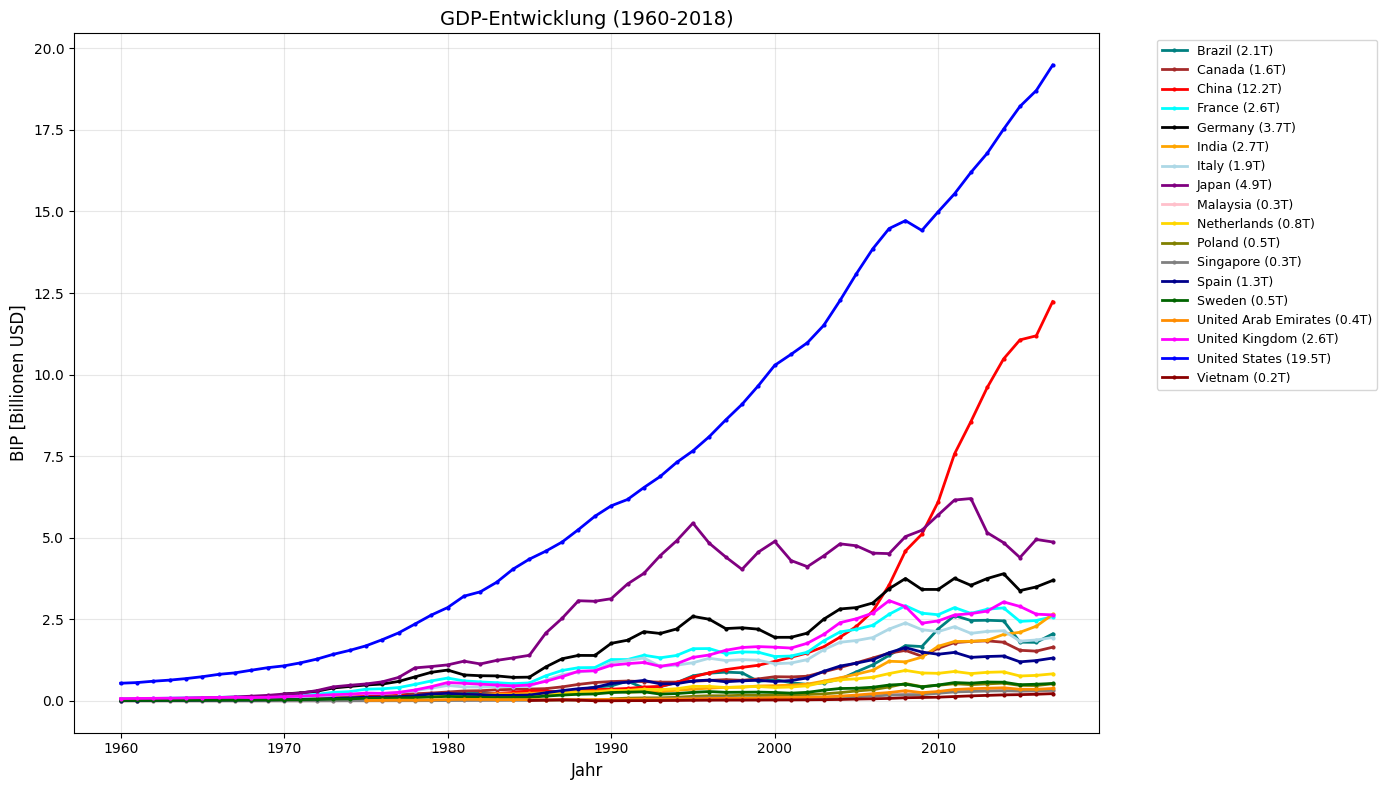

GDP-Zeitreihen: 18 Länder geplottet

2. Wirtschaftsstruktur-Entwicklung (1960-2018)


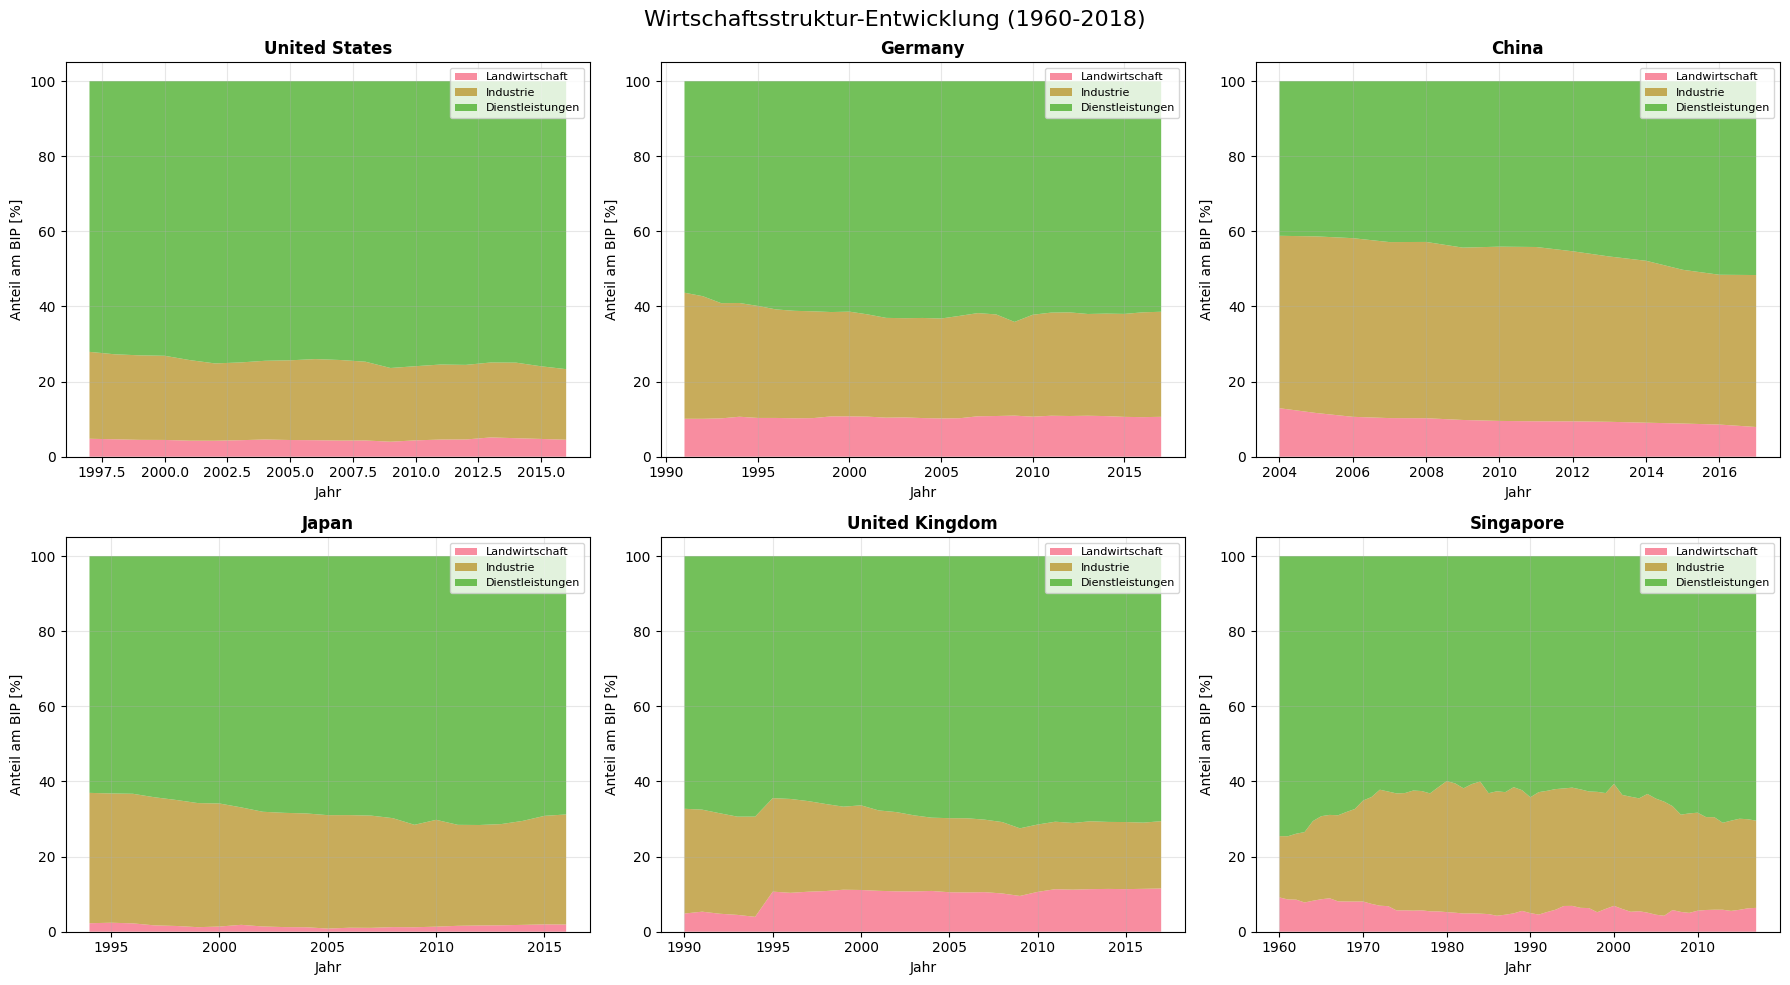

Wirtschaftsstruktur für 6 Länder visualisiert

3. BIP-Vergleich für besondere Jahre
Vergleich basierend auf: Nominales Bruttoinlandsprodukt (GDP)
1989: 18 Länder verglichen
2008: 19 Länder verglichen
2015: 19 Länder verglichen


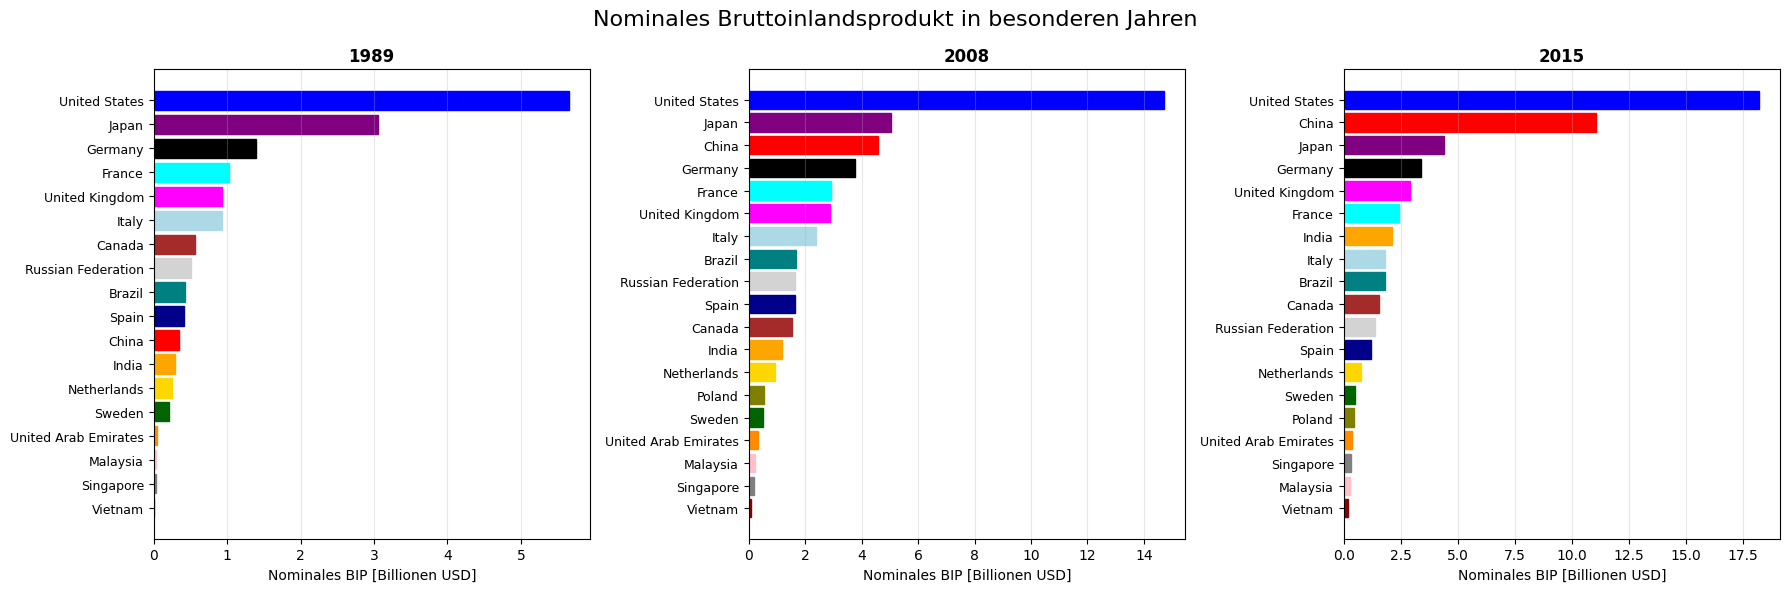

In [12]:
# Länderauswahl für Wirtschaftsdaten
selected_countries_econ = get_selected_countries(df_econ, 'GDP_current_USD')
df_econ_selected = df_econ[df_econ['Country'].isin(selected_countries_econ)]

# 1. GDP-Entwicklung über Zeit (Zeitreihen 1960-2018)
print("\n1. GDP-Entwicklung der größten Volkswirtschaften (1960-2018)")

plt.figure(figsize=(14, 8))
plotted_gdp = 0

# Verwende die ausgewählten Länder aus der config
for country in selected_countries_econ:
    if country in country_colors:  # Nur Länder mit definierten Farben
        country_data = df_econ[df_econ['Country'] == country].sort_values('Year')
        valid_data = country_data[country_data['GDP_current_USD'].notna()]
        
        if len(valid_data) > 10:  # Mindestens 10 Jahre Daten für sinnvolle Zeitreihe
            # Aktuellster verfügbarer GDP-Wert
            latest_gdp = valid_data['GDP_current_USD'].iloc[-1]
            
            plt.plot(valid_data['Year'], valid_data['GDP_current_USD'] / 1e12,
                    label=f"{country} ({latest_gdp/1e12:.1f}T)",
                    color=country_colors[country], linewidth=2, marker='o', markersize=2)
            plotted_gdp += 1

plt.title('GDP-Entwicklung (1960-2018)', fontsize=14)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('BIP [Billionen USD]', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

print(f"GDP-Zeitreihen: {plotted_gdp} Länder geplottet")

# 2. Wirtschaftsstruktur Evolution (1960-2018)
print("\n2. Wirtschaftsstruktur-Entwicklung (1960-2018)")

# Repräsentative Länder für Strukturwandel
structure_countries = ['United States', 'Germany', 'China', 'Japan', 'United Kingdom', 'Singapore']
structure_countries = [c for c in structure_countries if c in country_colors]

if 'Industry_share_GDP' in df_econ.columns and 'Services_share_GDP' in df_econ.columns:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, country in enumerate(structure_countries[:6]):
        if i < len(axes):
            country_data = df_econ[df_econ['Country'] == country].sort_values('Year')
            # Vollständige Struktur-Daten
            complete_data = country_data[
                (country_data['Industry_share_GDP'].notna()) & 
                (country_data['Services_share_GDP'].notna())
            ].copy()
            
            if len(complete_data) > 5:
                # Landwirtschaftsanteil berechnen (Rest)
                complete_data['Agriculture_share_GDP'] = (100 - 
                    complete_data['Industry_share_GDP'] - 
                    complete_data['Services_share_GDP'])
                
                # Stacked Area Plot
                axes[i].stackplot(complete_data['Year'],
                                complete_data['Agriculture_share_GDP'],
                                complete_data['Industry_share_GDP'],
                                complete_data['Services_share_GDP'],
                                labels=['Landwirtschaft', 'Industrie', 'Dienstleistungen'],
                                alpha=0.8)
                
                axes[i].set_title(f'{country}', fontsize=12, fontweight='bold')
                axes[i].set_xlabel('Jahr', fontsize=10)
                axes[i].set_ylabel('Anteil am BIP [%]', fontsize=10)
                axes[i].grid(True, alpha=0.3)
                axes[i].legend(loc='upper right', fontsize=8)
    
    # Leere Subplots ausblenden
    for i in range(len(structure_countries), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Wirtschaftsstruktur-Entwicklung (1960-2018)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Wirtschaftsstruktur für {len(structure_countries)} Länder visualisiert")

# 3. GDP-Snapshots für besondere Jahre
print("\n3. BIP-Vergleich für besondere Jahre")
print("Vergleich basierend auf: Nominales Bruttoinlandsprodukt (GDP)")

# Besondere Jahre definieren
special_years = [1989, 2008, 2015]  # Fall der Mauer, Finanzkrise, Paris-Abkommen
available_years = [year for year in special_years if year in df_econ['Year'].values]

if len(available_years) > 0:
    # Layout: 1 Zeile, 3 Spalten für die 3 Jahre (wie bei CO2)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Falls nur 1 oder 2 Jahre verfügbar, axes in Liste umwandeln
    if len(available_years) == 1:
        axes = [axes]
    
    for i, year in enumerate(available_years):
        if i < len(axes):
            year_data = df_econ[
                (df_econ['Year'] == year) & 
                (df_econ['Country'].isin(selected_countries_econ)) &
                (df_econ['GDP_current_USD'].notna())
            ].copy()
            
            if len(year_data) >= 5:  # Mindestens 5 Länder
                year_data = year_data.sort_values('GDP_current_USD', ascending=True)
                
                # Balkendiagramm für jedes Jahr
                bars = axes[i].barh(range(len(year_data)), year_data['GDP_current_USD'] / 1e12)
                
                # Länder-spezifische Farben
                for j, country in enumerate(year_data['Country']):
                    color = country_colors.get(country, 'lightgray')
                    bars[j].set_color(color)
                
                axes[i].set_yticks(range(len(year_data)))
                axes[i].set_yticklabels(year_data['Country'], fontsize=9)
                axes[i].set_xlabel('Nominales BIP [Billionen USD]', fontsize=10)  # Klarstellung!
                axes[i].set_title(f'{year}', fontsize=12, fontweight='bold')
                axes[i].grid(True, alpha=0.3, axis='x')
                
                print(f"{year}: {len(year_data)} Länder verglichen")
    
    # Leere Subplots ausblenden
    for i in range(len(available_years), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Nominales Bruttoinlandsprodukt in besonderen Jahren', fontsize=16)  # Spezifisch!
    plt.tight_layout()
    plt.show()
else:
    print("Keine der besonderen Jahre verfügbar in Wirtschaftsdaten")


5. Urbanisierungsentwicklung (1960-2018)


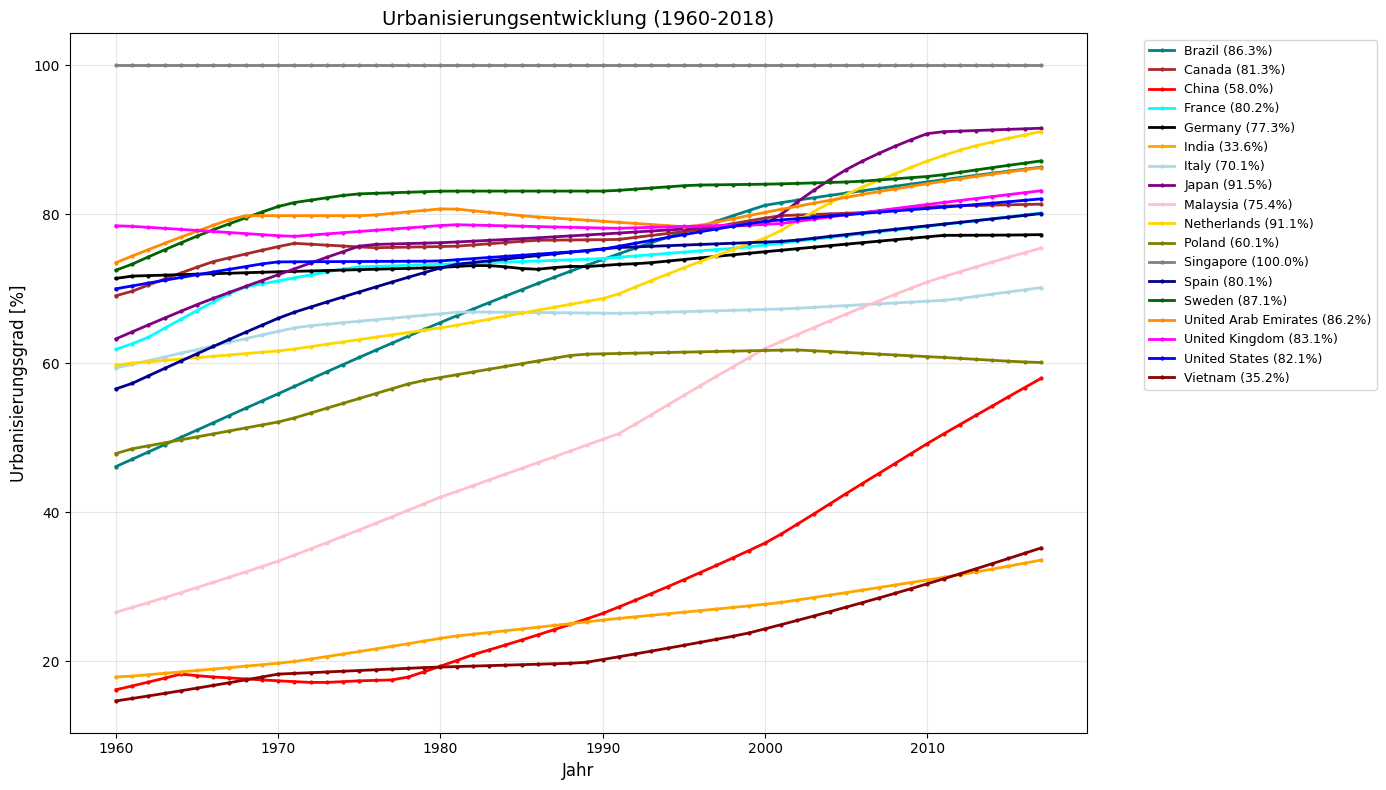

Urbanisierungstrends: 18 Länder geplottet


In [16]:
# 5. Urbanisierungsentwicklung über Zeit (1960-2018)
print("\n5. Urbanisierungsentwicklung (1960-2018)")

plt.figure(figsize=(14, 8))
plotted_urban = 0

for country in selected_countries_econ:
    if country in country_colors:  # Nur Länder mit definierten Farben
        country_data = df_econ[df_econ['Country'] == country].sort_values('Year')
        valid_data = country_data[country_data['Urban_population_pct'].notna()]
        
        if len(valid_data) > 10:  # Mindestens 10 Jahre Daten für sinnvolle Zeitreihe
            # Aktuellster verfügbarer Urbanisierungswert
            latest_urban = valid_data['Urban_population_pct'].iloc[-1]
            
            plt.plot(valid_data['Year'], valid_data['Urban_population_pct'],
                    label=f"{country} ({latest_urban:.1f}%)",  # Aktueller Wert in Legende
                    color=country_colors[country], linewidth=2, marker='o', markersize=2)
            plotted_urban += 1

plt.title('Urbanisierungsentwicklung (1960-2018)', fontsize=14)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Urbanisierungsgrad [%]', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)  # Legende hinzugefügt!
plt.tight_layout()
plt.show()

print(f"Urbanisierungstrends: {plotted_urban} Länder geplottet")